# Import

In [35]:
import torch
from torch import nn
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR, CosineAnnealingLR
from fvcore.nn import FlopCountAnalysis, flop_count_table
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [36]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
# OPTIMIZER = "SGD"
OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"
"""Learning rate scheduler parameters"""
NUM_EPOCHS = 180

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 150

file_path = f"MyResNet32_{BATCH}_{OPTIMIZER}"

In [37]:
file_path

'MyResNet34_128_SGD_nasterov'

# Loading the dataset

## Define Dateloader

In [38]:
tmp = LoadDataset(root="../../data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [39]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
test.transforms = ToTensor() 128


# Define ResNet

## Model Confirm

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [41]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [42]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [43]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [44]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_path)

## (4) Define Learning Rate schedualer

In [45]:
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=0)

## (5) Define AMP scaler

In [46]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [47]:
if os.path.exists(file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

Suceessfully loaded the All setting and Log file.
MyResNet34_128_SGD_nasterov
Current epoch is 23
Current learning rate: 0.1


In [48]:
optimizer.param_groups[0]["lr"]

0.1

In [49]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [50]:
if valid_data is None:
    valid_dataloader = None
if test_data is None:
    test_dataloader = None

In [51]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 24/180] :


24 Train: 100%|██████| 391/391 [00:16<00:00, 24.09it/s]

Train Loss: 0.8993 | Train Acc: 68.76%


Test  Loss: 1.0570 | Test Acc: 64.80%
updated best eval loss : 1.056959408747999
--------------------------------------------------
[Epoch 25/180] :


25 Train: 100%|██████| 391/391 [00:15<00:00, 25.24it/s]


Train Loss: 0.8367 | Train Acc: 71.12%
Test  Loss: 0.7714 | Test Acc: 73.50%
updated best eval loss : 0.7713810695877558
--------------------------------------------------
[Epoch 26/180] :


26 Train: 100%|██████| 391/391 [00:15<00:00, 24.79it/s]


Train Loss: 0.7789 | Train Acc: 72.99%
Test  Loss: 0.6795 | Test Acc: 76.76%
updated best eval loss : 0.6795277108874502
--------------------------------------------------
[Epoch 27/180] :


27 Train: 100%|██████| 391/391 [00:15<00:00, 24.74it/s]


Train Loss: 0.7460 | Train Acc: 74.07%
Test  Loss: 0.7243 | Test Acc: 74.32%
--------------------------------------------------
[Epoch 28/180] :


28 Train: 100%|██████| 391/391 [00:16<00:00, 23.62it/s]


Train Loss: 0.7112 | Train Acc: 75.26%
Test  Loss: 0.8913 | Test Acc: 69.48%
--------------------------------------------------
[Epoch 29/180] :


29 Train: 100%|██████| 391/391 [00:15<00:00, 25.12it/s]


Train Loss: 0.6837 | Train Acc: 76.22%
Test  Loss: 0.9251 | Test Acc: 72.42%
--------------------------------------------------
[Epoch 30/180] :


30 Train: 100%|██████| 391/391 [00:16<00:00, 23.95it/s]


Train Loss: 0.6631 | Train Acc: 76.88%
Test  Loss: 0.7389 | Test Acc: 75.95%
--------------------------------------------------
[Epoch 31/180] :


31 Train: 100%|██████| 391/391 [00:15<00:00, 25.40it/s]


Train Loss: 0.6456 | Train Acc: 77.65%
Test  Loss: 0.6860 | Test Acc: 76.62%
--------------------------------------------------
[Epoch 32/180] :


32 Train: 100%|██████| 391/391 [00:16<00:00, 24.18it/s]


Train Loss: 0.6292 | Train Acc: 78.09%
Test  Loss: 0.6852 | Test Acc: 77.35%
--------------------------------------------------
[Epoch 33/180] :


33 Train: 100%|██████| 391/391 [00:15<00:00, 25.29it/s]


Train Loss: 0.6113 | Train Acc: 78.72%
Test  Loss: 0.6164 | Test Acc: 78.98%
updated best eval loss : 0.6163595126399511
--------------------------------------------------
[Epoch 34/180] :


34 Train: 100%|██████| 391/391 [00:16<00:00, 23.75it/s]


Train Loss: 0.5978 | Train Acc: 79.29%
Test  Loss: 0.9723 | Test Acc: 69.84%
--------------------------------------------------
[Epoch 35/180] :


35 Train: 100%|██████| 391/391 [00:15<00:00, 24.82it/s]


Train Loss: 0.5935 | Train Acc: 79.54%
Test  Loss: 0.6450 | Test Acc: 77.75%
--------------------------------------------------
[Epoch 36/180] :


36 Train: 100%|██████| 391/391 [00:15<00:00, 25.34it/s]


Train Loss: 0.5774 | Train Acc: 80.01%
Test  Loss: 0.5012 | Test Acc: 82.21%
updated best eval loss : 0.5012117126319982
--------------------------------------------------
[Epoch 37/180] :


37 Train: 100%|██████| 391/391 [00:15<00:00, 24.74it/s]


Train Loss: 0.5694 | Train Acc: 80.32%
Test  Loss: 0.6502 | Test Acc: 77.75%
--------------------------------------------------
[Epoch 38/180] :


38 Train: 100%|██████| 391/391 [00:15<00:00, 25.54it/s]


Train Loss: 0.5658 | Train Acc: 80.29%
Test  Loss: 0.6589 | Test Acc: 77.29%
--------------------------------------------------
[Epoch 39/180] :


39 Train: 100%|██████| 391/391 [00:16<00:00, 24.19it/s]


Train Loss: 0.5503 | Train Acc: 80.88%
Test  Loss: 0.8109 | Test Acc: 73.24%
--------------------------------------------------
[Epoch 40/180] :


40 Train: 100%|██████| 391/391 [00:16<00:00, 24.16it/s]


Train Loss: 0.5487 | Train Acc: 80.97%
Test  Loss: 0.7360 | Test Acc: 77.08%
--------------------------------------------------
[Epoch 41/180] :


41 Train: 100%|██████| 391/391 [00:16<00:00, 24.31it/s]


Train Loss: 0.5364 | Train Acc: 81.45%
Test  Loss: 0.6688 | Test Acc: 77.32%
--------------------------------------------------
[Epoch 42/180] :


42 Train: 100%|██████| 391/391 [00:15<00:00, 25.05it/s]


Train Loss: 0.5282 | Train Acc: 81.60%
Test  Loss: 0.5988 | Test Acc: 79.49%
--------------------------------------------------
[Epoch 43/180] :


43 Train: 100%|██████| 391/391 [00:14<00:00, 26.25it/s]


Train Loss: 0.5265 | Train Acc: 81.73%
Test  Loss: 0.5995 | Test Acc: 79.41%
--------------------------------------------------
[Epoch 44/180] :


44 Train: 100%|██████| 391/391 [00:15<00:00, 26.02it/s]


Train Loss: 0.5206 | Train Acc: 81.97%
Test  Loss: 0.7311 | Test Acc: 76.82%
--------------------------------------------------
[Epoch 45/180] :


45 Train: 100%|██████| 391/391 [00:15<00:00, 25.45it/s]


Train Loss: 0.5171 | Train Acc: 82.14%
Test  Loss: 0.5607 | Test Acc: 81.02%
--------------------------------------------------
[Epoch 46/180] :


46 Train: 100%|██████| 391/391 [00:15<00:00, 24.72it/s]


Train Loss: 0.5045 | Train Acc: 82.48%
Test  Loss: 0.8533 | Test Acc: 72.96%
--------------------------------------------------
[Epoch 47/180] :


47 Train: 100%|██████| 391/391 [00:15<00:00, 25.22it/s]


Train Loss: 0.5039 | Train Acc: 82.58%
Test  Loss: 0.6065 | Test Acc: 80.20%
--------------------------------------------------
[Epoch 48/180] :


48 Train: 100%|██████| 391/391 [00:15<00:00, 24.45it/s]


Train Loss: 0.5001 | Train Acc: 82.70%
Test  Loss: 0.8072 | Test Acc: 74.47%
--------------------------------------------------
[Epoch 49/180] :


49 Train: 100%|██████| 391/391 [00:15<00:00, 25.08it/s]


Train Loss: 0.4973 | Train Acc: 82.67%
Test  Loss: 0.9050 | Test Acc: 72.22%
--------------------------------------------------
[Epoch 50/180] :


50 Train: 100%|██████| 391/391 [00:16<00:00, 24.18it/s]


Train Loss: 0.4854 | Train Acc: 83.12%
Test  Loss: 0.5770 | Test Acc: 80.93%
--------------------------------------------------
[Epoch 51/180] :


51 Train: 100%|██████| 391/391 [00:15<00:00, 25.16it/s]


Train Loss: 0.4862 | Train Acc: 83.32%
Test  Loss: 0.5164 | Test Acc: 82.13%
--------------------------------------------------
[Epoch 52/180] :


52 Train: 100%|██████| 391/391 [00:16<00:00, 24.22it/s]


Train Loss: 0.4842 | Train Acc: 83.22%
Test  Loss: 0.7381 | Test Acc: 76.03%
--------------------------------------------------
[Epoch 53/180] :


53 Train: 100%|██████| 391/391 [00:15<00:00, 24.88it/s]


Train Loss: 0.4815 | Train Acc: 83.57%
Test  Loss: 0.5815 | Test Acc: 80.46%
--------------------------------------------------
[Epoch 54/180] :


54 Train: 100%|██████| 391/391 [00:15<00:00, 25.25it/s]


Train Loss: 0.4760 | Train Acc: 83.26%
Test  Loss: 0.5923 | Test Acc: 80.67%
--------------------------------------------------
[Epoch 55/180] :


55 Train: 100%|██████| 391/391 [00:15<00:00, 25.51it/s]


Train Loss: 0.4731 | Train Acc: 83.63%
Test  Loss: 0.6774 | Test Acc: 78.62%
--------------------------------------------------
[Epoch 56/180] :


56 Train: 100%|██████| 391/391 [00:16<00:00, 23.07it/s]


Train Loss: 0.4645 | Train Acc: 83.83%
Test  Loss: 0.5457 | Test Acc: 81.94%
--------------------------------------------------
[Epoch 57/180] :


57 Train: 100%|██████| 391/391 [00:16<00:00, 23.76it/s]


Train Loss: 0.4669 | Train Acc: 83.78%
Test  Loss: 0.5341 | Test Acc: 82.17%
--------------------------------------------------
[Epoch 58/180] :


58 Train: 100%|██████| 391/391 [00:15<00:00, 24.68it/s]


Train Loss: 0.4698 | Train Acc: 83.65%
Test  Loss: 0.5494 | Test Acc: 81.97%
--------------------------------------------------
[Epoch 59/180] :


59 Train: 100%|██████| 391/391 [00:16<00:00, 23.86it/s]


Train Loss: 0.4649 | Train Acc: 83.91%
Test  Loss: 0.5340 | Test Acc: 82.70%
--------------------------------------------------
[Epoch 60/180] :


60 Train: 100%|██████| 391/391 [00:14<00:00, 26.22it/s]


Train Loss: 0.4616 | Train Acc: 84.11%
Test  Loss: 0.5772 | Test Acc: 81.01%
--------------------------------------------------
[Epoch 61/180] :


61 Train: 100%|██████| 391/391 [00:16<00:00, 24.28it/s]


Train Loss: 0.4562 | Train Acc: 84.08%
Test  Loss: 0.8819 | Test Acc: 72.09%
--------------------------------------------------
[Epoch 62/180] :


62 Train: 100%|██████| 391/391 [00:16<00:00, 23.86it/s]


Train Loss: 0.4555 | Train Acc: 84.22%
Test  Loss: 0.5638 | Test Acc: 80.96%
--------------------------------------------------
[Epoch 63/180] :


63 Train: 100%|██████| 391/391 [00:16<00:00, 24.00it/s]


Train Loss: 0.4565 | Train Acc: 84.18%
Test  Loss: 0.8341 | Test Acc: 74.05%
--------------------------------------------------
[Epoch 64/180] :


64 Train: 100%|██████| 391/391 [00:16<00:00, 23.82it/s]


Train Loss: 0.4527 | Train Acc: 84.32%
Test  Loss: 0.6383 | Test Acc: 79.52%
--------------------------------------------------
[Epoch 65/180] :


65 Train: 100%|██████| 391/391 [00:15<00:00, 25.11it/s]


Train Loss: 0.4479 | Train Acc: 84.47%
Test  Loss: 0.4959 | Test Acc: 83.15%
updated best eval loss : 0.49590233477610574
--------------------------------------------------
[Epoch 66/180] :


66 Train: 100%|██████| 391/391 [00:15<00:00, 24.72it/s]


Train Loss: 0.4449 | Train Acc: 84.40%
Test  Loss: 0.5744 | Test Acc: 81.33%
--------------------------------------------------
[Epoch 67/180] :


67 Train: 100%|██████| 391/391 [00:15<00:00, 25.37it/s]


Train Loss: 0.4474 | Train Acc: 84.50%
Test  Loss: 0.4681 | Test Acc: 84.69%
updated best eval loss : 0.4681105843827694
--------------------------------------------------
[Epoch 68/180] :


68 Train: 100%|██████| 391/391 [00:15<00:00, 25.33it/s]


Train Loss: 0.4425 | Train Acc: 84.68%
Test  Loss: 0.6558 | Test Acc: 79.43%
--------------------------------------------------
[Epoch 69/180] :


69 Train: 100%|██████| 391/391 [00:16<00:00, 23.47it/s]


Train Loss: 0.4394 | Train Acc: 84.91%
Test  Loss: 0.5366 | Test Acc: 81.93%
--------------------------------------------------
[Epoch 70/180] :


70 Train: 100%|██████| 391/391 [00:15<00:00, 24.58it/s]


Train Loss: 0.4381 | Train Acc: 84.73%
Test  Loss: 0.6181 | Test Acc: 81.03%
--------------------------------------------------
[Epoch 71/180] :


71 Train: 100%|██████| 391/391 [00:15<00:00, 25.40it/s]


Train Loss: 0.4336 | Train Acc: 84.95%
Test  Loss: 0.4772 | Test Acc: 84.11%
--------------------------------------------------
[Epoch 72/180] :


72 Train: 100%|██████| 391/391 [00:16<00:00, 23.29it/s]


Train Loss: 0.4322 | Train Acc: 85.06%
Test  Loss: 0.6090 | Test Acc: 80.57%
--------------------------------------------------
[Epoch 73/180] :


73 Train: 100%|██████| 391/391 [00:16<00:00, 24.28it/s]


Train Loss: 0.4309 | Train Acc: 84.96%
Test  Loss: 0.4647 | Test Acc: 84.82%
updated best eval loss : 0.46469275219531
--------------------------------------------------
[Epoch 74/180] :


74 Train: 100%|██████| 391/391 [00:15<00:00, 24.79it/s]


Train Loss: 0.4287 | Train Acc: 85.17%
Test  Loss: 0.5220 | Test Acc: 82.98%
--------------------------------------------------
[Epoch 75/180] :


75 Train: 100%|██████| 391/391 [00:16<00:00, 24.02it/s]


Train Loss: 0.4277 | Train Acc: 85.21%
Test  Loss: 0.4742 | Test Acc: 84.56%
--------------------------------------------------
[Epoch 76/180] :


76 Train: 100%|██████| 391/391 [00:15<00:00, 24.93it/s]


Train Loss: 0.4279 | Train Acc: 85.10%
Test  Loss: 0.5398 | Test Acc: 82.65%
--------------------------------------------------
[Epoch 77/180] :


77 Train: 100%|██████| 391/391 [00:15<00:00, 24.67it/s]


Train Loss: 0.4206 | Train Acc: 85.37%
Test  Loss: 0.6607 | Test Acc: 79.16%
--------------------------------------------------
[Epoch 78/180] :


78 Train: 100%|██████| 391/391 [00:15<00:00, 25.54it/s]


Train Loss: 0.4210 | Train Acc: 85.33%
Test  Loss: 0.4800 | Test Acc: 84.04%
--------------------------------------------------
[Epoch 79/180] :


79 Train: 100%|██████| 391/391 [00:14<00:00, 26.14it/s]


Train Loss: 0.4259 | Train Acc: 85.22%
Test  Loss: 0.5590 | Test Acc: 82.02%
--------------------------------------------------
[Epoch 80/180] :


80 Train: 100%|██████| 391/391 [00:15<00:00, 26.00it/s]


Train Loss: 0.4240 | Train Acc: 85.08%
Test  Loss: 0.5354 | Test Acc: 82.62%
--------------------------------------------------
[Epoch 81/180] :


81 Train: 100%|██████| 391/391 [00:16<00:00, 24.42it/s]


Train Loss: 0.4172 | Train Acc: 85.38%
Test  Loss: 0.5774 | Test Acc: 80.95%
--------------------------------------------------
[Epoch 82/180] :


82 Train: 100%|██████| 391/391 [00:15<00:00, 24.76it/s]


Train Loss: 0.4189 | Train Acc: 85.39%
Test  Loss: 0.4780 | Test Acc: 84.04%
--------------------------------------------------
[Epoch 83/180] :


83 Train: 100%|██████| 391/391 [00:16<00:00, 24.36it/s]


Train Loss: 0.4147 | Train Acc: 85.61%
Test  Loss: 0.5395 | Test Acc: 82.13%
--------------------------------------------------
[Epoch 84/180] :


84 Train: 100%|██████| 391/391 [00:15<00:00, 24.80it/s]


Train Loss: 0.4224 | Train Acc: 85.14%
Test  Loss: 0.5031 | Test Acc: 83.46%
--------------------------------------------------
[Epoch 85/180] :


85 Train: 100%|██████| 391/391 [00:15<00:00, 25.97it/s]


Train Loss: 0.4171 | Train Acc: 85.51%
Test  Loss: 0.4899 | Test Acc: 83.85%
--------------------------------------------------
[Epoch 86/180] :


86 Train: 100%|██████| 391/391 [00:15<00:00, 25.18it/s]


Train Loss: 0.4201 | Train Acc: 85.31%
Test  Loss: 0.4566 | Test Acc: 84.59%
updated best eval loss : 0.45657481913325154
--------------------------------------------------
[Epoch 87/180] :


87 Train: 100%|██████| 391/391 [00:15<00:00, 24.76it/s]


Train Loss: 0.4116 | Train Acc: 85.86%
Test  Loss: 0.7076 | Test Acc: 78.15%
--------------------------------------------------
[Epoch 88/180] :


88 Train: 100%|██████| 391/391 [00:16<00:00, 24.13it/s]


Train Loss: 0.4160 | Train Acc: 85.65%
Test  Loss: 0.7537 | Test Acc: 75.80%
--------------------------------------------------
[Epoch 89/180] :


89 Train: 100%|██████| 391/391 [00:14<00:00, 26.17it/s]


Train Loss: 0.4088 | Train Acc: 85.85%
Test  Loss: 0.4689 | Test Acc: 84.37%
--------------------------------------------------
[Epoch 90/180] :


90 Train: 100%|██████| 391/391 [00:15<00:00, 25.21it/s]


Train Loss: 0.4136 | Train Acc: 85.63%
Test  Loss: 0.5386 | Test Acc: 82.21%
--------------------------------------------------
[Epoch 91/180] :


91 Train: 100%|██████| 391/391 [00:16<00:00, 23.74it/s]


Train Loss: 0.4105 | Train Acc: 85.71%
Test  Loss: 0.5899 | Test Acc: 81.12%
--------------------------------------------------
[Epoch 92/180] :


92 Train: 100%|██████| 391/391 [00:15<00:00, 24.87it/s]


Train Loss: 0.4145 | Train Acc: 85.43%
Test  Loss: 0.4894 | Test Acc: 84.55%
--------------------------------------------------
[Epoch 93/180] :


93 Train: 100%|██████| 391/391 [00:14<00:00, 26.10it/s]


Train Loss: 0.4048 | Train Acc: 85.82%
Test  Loss: 0.5396 | Test Acc: 82.93%
--------------------------------------------------
[Epoch 94/180] :


94 Train: 100%|██████| 391/391 [00:16<00:00, 23.29it/s]


Train Loss: 0.4097 | Train Acc: 85.62%
Test  Loss: 0.5884 | Test Acc: 81.20%
--------------------------------------------------
[Epoch 95/180] :


95 Train: 100%|██████| 391/391 [00:15<00:00, 24.81it/s]


Train Loss: 0.4058 | Train Acc: 86.03%
Test  Loss: 0.4407 | Test Acc: 85.74%
updated best eval loss : 0.44066605122783514
--------------------------------------------------
[Epoch 96/180] :


96 Train: 100%|██████| 391/391 [00:15<00:00, 24.84it/s]


Train Loss: 0.4012 | Train Acc: 86.07%
Test  Loss: 0.5765 | Test Acc: 81.95%
--------------------------------------------------
[Epoch 97/180] :


97 Train: 100%|██████| 391/391 [00:16<00:00, 24.11it/s]


Train Loss: 0.4033 | Train Acc: 85.91%
Test  Loss: 0.5332 | Test Acc: 82.48%
--------------------------------------------------
[Epoch 98/180] :


98 Train: 100%|██████| 391/391 [00:15<00:00, 24.58it/s]


Train Loss: 0.4019 | Train Acc: 86.02%
Test  Loss: 0.4643 | Test Acc: 84.29%
--------------------------------------------------
[Epoch 99/180] :


99 Train: 100%|██████| 391/391 [00:15<00:00, 24.58it/s]


Train Loss: 0.4030 | Train Acc: 86.03%
Test  Loss: 0.5065 | Test Acc: 83.59%
--------------------------------------------------
[Epoch 100/180] :


100 Train: 100%|█████| 391/391 [00:16<00:00, 24.12it/s]


Train Loss: 0.3966 | Train Acc: 86.36%
Test  Loss: 0.4567 | Test Acc: 84.81%
--------------------------------------------------
[Epoch 101/180] :


101 Train: 100%|█████| 391/391 [00:15<00:00, 24.53it/s]


Train Loss: 0.4004 | Train Acc: 86.07%
Test  Loss: 0.5669 | Test Acc: 81.71%
--------------------------------------------------
[Epoch 102/180] :


102 Train: 100%|█████| 391/391 [00:15<00:00, 25.35it/s]


Train Loss: 0.4020 | Train Acc: 86.13%
Test  Loss: 0.5131 | Test Acc: 82.90%
--------------------------------------------------
[Epoch 103/180] :


103 Train: 100%|█████| 391/391 [00:15<00:00, 25.64it/s]


Train Loss: 0.3960 | Train Acc: 86.21%
Test  Loss: 0.4454 | Test Acc: 85.39%
--------------------------------------------------
[Epoch 104/180] :


104 Train: 100%|█████| 391/391 [00:16<00:00, 24.41it/s]


Train Loss: 0.3933 | Train Acc: 86.24%
Test  Loss: 0.4934 | Test Acc: 83.91%
--------------------------------------------------
[Epoch 105/180] :


105 Train: 100%|█████| 391/391 [00:15<00:00, 24.71it/s]


Train Loss: 0.4025 | Train Acc: 85.99%
Test  Loss: 0.4909 | Test Acc: 83.57%
--------------------------------------------------
[Epoch 106/180] :


106 Train: 100%|█████| 391/391 [00:16<00:00, 24.39it/s]


Train Loss: 0.3952 | Train Acc: 86.21%
Test  Loss: 0.5669 | Test Acc: 81.77%
--------------------------------------------------
[Epoch 107/180] :


107 Train: 100%|█████| 391/391 [00:15<00:00, 24.81it/s]


Train Loss: 0.3941 | Train Acc: 86.34%
Test  Loss: 0.6866 | Test Acc: 79.00%
--------------------------------------------------
[Epoch 108/180] :


108 Train: 100%|█████| 391/391 [00:15<00:00, 25.37it/s]


Train Loss: 0.3919 | Train Acc: 86.35%
Test  Loss: 0.6079 | Test Acc: 80.35%
--------------------------------------------------
[Epoch 109/180] :


109 Train: 100%|█████| 391/391 [00:15<00:00, 25.04it/s]


Train Loss: 0.3889 | Train Acc: 86.51%
Test  Loss: 0.5524 | Test Acc: 81.78%
--------------------------------------------------
[Epoch 110/180] :


110 Train: 100%|█████| 391/391 [00:15<00:00, 25.34it/s]


Train Loss: 0.3922 | Train Acc: 86.37%
Test  Loss: 0.5204 | Test Acc: 83.51%
--------------------------------------------------
[Epoch 111/180] :


111 Train: 100%|█████| 391/391 [00:15<00:00, 24.81it/s]


Train Loss: 0.3944 | Train Acc: 86.28%
Test  Loss: 0.5268 | Test Acc: 82.71%
--------------------------------------------------
[Epoch 112/180] :


112 Train: 100%|█████| 391/391 [00:17<00:00, 22.80it/s]


Train Loss: 0.3947 | Train Acc: 86.22%
Test  Loss: 0.5216 | Test Acc: 83.45%
--------------------------------------------------
[Epoch 113/180] :


113 Train: 100%|█████| 391/391 [00:15<00:00, 25.23it/s]


Train Loss: 0.3907 | Train Acc: 86.46%
Test  Loss: 0.5468 | Test Acc: 82.18%
--------------------------------------------------
[Epoch 114/180] :


114 Train: 100%|█████| 391/391 [00:15<00:00, 25.64it/s]


Train Loss: 0.3876 | Train Acc: 86.54%
Test  Loss: 0.5821 | Test Acc: 80.48%
--------------------------------------------------
[Epoch 115/180] :


115 Train: 100%|█████| 391/391 [00:15<00:00, 24.89it/s]


Train Loss: 0.3881 | Train Acc: 86.51%
Test  Loss: 0.5171 | Test Acc: 83.09%
--------------------------------------------------
[Epoch 116/180] :


116 Train: 100%|█████| 391/391 [00:15<00:00, 25.05it/s]


Train Loss: 0.3868 | Train Acc: 86.51%
Test  Loss: 0.5202 | Test Acc: 83.04%
--------------------------------------------------
[Epoch 117/180] :


117 Train: 100%|█████| 391/391 [00:16<00:00, 23.92it/s]


Train Loss: 0.3907 | Train Acc: 86.53%
Test  Loss: 0.5393 | Test Acc: 82.16%
--------------------------------------------------
[Epoch 118/180] :


118 Train: 100%|█████| 391/391 [00:15<00:00, 24.65it/s]


Train Loss: 0.3853 | Train Acc: 86.69%
Test  Loss: 0.5076 | Test Acc: 83.34%
--------------------------------------------------
[Epoch 119/180] :


119 Train: 100%|█████| 391/391 [00:15<00:00, 25.03it/s]


Train Loss: 0.3852 | Train Acc: 86.56%
Test  Loss: 0.5605 | Test Acc: 82.65%
--------------------------------------------------
[Epoch 120/180] :


120 Train: 100%|█████| 391/391 [00:15<00:00, 25.83it/s]


Train Loss: 0.3853 | Train Acc: 86.56%
Test  Loss: 0.5083 | Test Acc: 83.40%
--------------------------------------------------
[Epoch 121/180] :


121 Train: 100%|█████| 391/391 [00:15<00:00, 24.78it/s]


Train Loss: 0.3931 | Train Acc: 86.23%
Test  Loss: 0.4986 | Test Acc: 83.64%
--------------------------------------------------
[Epoch 122/180] :


122 Train: 100%|█████| 391/391 [00:16<00:00, 24.19it/s]


Train Loss: 0.3829 | Train Acc: 86.53%
Test  Loss: 0.5102 | Test Acc: 83.18%
--------------------------------------------------
[Epoch 123/180] :


123 Train: 100%|█████| 391/391 [00:16<00:00, 24.13it/s]


Train Loss: 0.3872 | Train Acc: 86.55%
Test  Loss: 0.3968 | Test Acc: 86.82%
updated best eval loss : 0.3967994872150542
--------------------------------------------------
[Epoch 124/180] :


124 Train: 100%|█████| 391/391 [00:15<00:00, 24.78it/s]


Train Loss: 0.3822 | Train Acc: 86.58%
Test  Loss: 0.4599 | Test Acc: 84.47%
--------------------------------------------------
[Epoch 125/180] :


125 Train: 100%|█████| 391/391 [00:15<00:00, 25.03it/s]


Train Loss: 0.3902 | Train Acc: 86.45%
Test  Loss: 0.5224 | Test Acc: 82.72%
--------------------------------------------------
[Epoch 126/180] :


126 Train: 100%|█████| 391/391 [00:15<00:00, 25.10it/s]


Train Loss: 0.3851 | Train Acc: 86.67%
Test  Loss: 0.5338 | Test Acc: 82.56%
--------------------------------------------------
[Epoch 127/180] :


127 Train: 100%|█████| 391/391 [00:15<00:00, 25.40it/s]


Train Loss: 0.3820 | Train Acc: 86.71%
Test  Loss: 0.5878 | Test Acc: 80.85%
--------------------------------------------------
[Epoch 128/180] :


128 Train: 100%|█████| 391/391 [00:15<00:00, 25.55it/s]


Train Loss: 0.3830 | Train Acc: 86.68%
Test  Loss: 0.5158 | Test Acc: 82.89%
--------------------------------------------------
[Epoch 129/180] :


129 Train: 100%|█████| 391/391 [00:15<00:00, 24.46it/s]


Train Loss: 0.3840 | Train Acc: 86.62%
Test  Loss: 0.5498 | Test Acc: 82.57%
--------------------------------------------------
[Epoch 130/180] :


130 Train: 100%|█████| 391/391 [00:16<00:00, 23.52it/s]


Train Loss: 0.3834 | Train Acc: 86.63%
Test  Loss: 0.5668 | Test Acc: 81.43%
--------------------------------------------------
[Epoch 131/180] :


131 Train: 100%|█████| 391/391 [00:15<00:00, 25.33it/s]


Train Loss: 0.3827 | Train Acc: 86.62%
Test  Loss: 0.5287 | Test Acc: 83.04%
--------------------------------------------------
[Epoch 132/180] :


132 Train: 100%|█████| 391/391 [00:15<00:00, 24.65it/s]


Train Loss: 0.3759 | Train Acc: 86.99%
Test  Loss: 0.5303 | Test Acc: 82.64%
--------------------------------------------------
[Epoch 133/180] :


133 Train: 100%|█████| 391/391 [00:15<00:00, 24.90it/s]


Train Loss: 0.3822 | Train Acc: 86.66%
Test  Loss: 0.5546 | Test Acc: 81.99%
--------------------------------------------------
[Epoch 134/180] :


134 Train: 100%|█████| 391/391 [00:16<00:00, 23.52it/s]


Train Loss: 0.3791 | Train Acc: 86.71%
Test  Loss: 0.5246 | Test Acc: 82.66%
--------------------------------------------------
[Epoch 135/180] :


135 Train: 100%|█████| 391/391 [00:16<00:00, 23.84it/s]


Train Loss: 0.3782 | Train Acc: 86.86%
Test  Loss: 0.5300 | Test Acc: 82.90%
--------------------------------------------------
[Epoch 136/180] :


136 Train: 100%|█████| 391/391 [00:15<00:00, 24.85it/s]


Train Loss: 0.3778 | Train Acc: 86.87%
Test  Loss: 0.5535 | Test Acc: 81.72%
--------------------------------------------------
[Epoch 137/180] :


137 Train: 100%|█████| 391/391 [00:15<00:00, 25.92it/s]


Train Loss: 0.3796 | Train Acc: 86.85%
Test  Loss: 0.4266 | Test Acc: 85.65%
--------------------------------------------------
[Epoch 138/180] :


138 Train: 100%|█████| 391/391 [00:16<00:00, 24.23it/s]


Train Loss: 0.3794 | Train Acc: 86.76%
Test  Loss: 0.5226 | Test Acc: 82.86%
--------------------------------------------------
[Epoch 139/180] :


139 Train: 100%|█████| 391/391 [00:15<00:00, 25.70it/s]


Train Loss: 0.3814 | Train Acc: 86.57%
Test  Loss: 0.4289 | Test Acc: 86.16%
--------------------------------------------------
[Epoch 140/180] :


140 Train: 100%|█████| 391/391 [00:15<00:00, 25.12it/s]


Train Loss: 0.3789 | Train Acc: 86.76%
Test  Loss: 0.4545 | Test Acc: 85.08%
--------------------------------------------------
[Epoch 141/180] :


141 Train: 100%|█████| 391/391 [00:15<00:00, 24.62it/s]


Train Loss: 0.3758 | Train Acc: 86.93%
Test  Loss: 0.5955 | Test Acc: 81.59%
--------------------------------------------------
[Epoch 142/180] :


142 Train: 100%|█████| 391/391 [00:15<00:00, 24.44it/s]


Train Loss: 0.3751 | Train Acc: 86.87%
Test  Loss: 0.5028 | Test Acc: 83.98%
--------------------------------------------------
[Epoch 143/180] :


143 Train: 100%|█████| 391/391 [00:15<00:00, 25.08it/s]


Train Loss: 0.3729 | Train Acc: 87.05%
Test  Loss: 0.5719 | Test Acc: 81.54%
--------------------------------------------------
[Epoch 144/180] :


144 Train: 100%|█████| 391/391 [00:12<00:00, 32.17it/s]


Train Loss: 0.3775 | Train Acc: 86.74%
Test  Loss: 0.5117 | Test Acc: 82.77%
--------------------------------------------------
[Epoch 145/180] :


145 Train: 100%|█████| 391/391 [00:12<00:00, 32.48it/s]


Train Loss: 0.3734 | Train Acc: 86.81%
Test  Loss: 0.4743 | Test Acc: 84.75%
--------------------------------------------------
[Epoch 146/180] :


146 Train: 100%|█████| 391/391 [00:12<00:00, 32.07it/s]


Train Loss: 0.3763 | Train Acc: 86.88%
Test  Loss: 0.5358 | Test Acc: 82.95%
--------------------------------------------------
[Epoch 147/180] :


147 Train: 100%|█████| 391/391 [00:11<00:00, 33.11it/s]


Train Loss: 0.3732 | Train Acc: 87.01%
Test  Loss: 0.5098 | Test Acc: 83.32%
--------------------------------------------------
[Epoch 148/180] :


148 Train: 100%|█████| 391/391 [00:12<00:00, 31.38it/s]


Train Loss: 0.3712 | Train Acc: 87.05%
Test  Loss: 0.4706 | Test Acc: 84.61%
--------------------------------------------------
[Epoch 149/180] :


149 Train: 100%|█████| 391/391 [00:12<00:00, 31.77it/s]


Train Loss: 0.3728 | Train Acc: 87.04%
Test  Loss: 0.4545 | Test Acc: 84.80%
--------------------------------------------------
[Epoch 150/180] :


150 Train: 100%|█████| 391/391 [00:14<00:00, 26.12it/s]


Train Loss: 0.3684 | Train Acc: 87.01%
Test  Loss: 0.4119 | Test Acc: 86.30%
--------------------------------------------------
[Epoch 151/180] :


151 Train: 100%|█████| 391/391 [00:15<00:00, 24.70it/s]


Train Loss: 0.3739 | Train Acc: 86.91%
Test  Loss: 0.4427 | Test Acc: 85.23%
--------------------------------------------------
[Epoch 152/180] :


152 Train: 100%|█████| 391/391 [00:16<00:00, 24.32it/s]


Train Loss: 0.3753 | Train Acc: 86.84%
Test  Loss: 0.5190 | Test Acc: 83.70%
--------------------------------------------------
[Epoch 153/180] :


153 Train: 100%|█████| 391/391 [00:16<00:00, 24.41it/s]


Train Loss: 0.3668 | Train Acc: 87.26%
Test  Loss: 0.4312 | Test Acc: 85.09%
--------------------------------------------------
[Epoch 154/180] :


154 Train: 100%|█████| 391/391 [00:15<00:00, 24.88it/s]


Train Loss: 0.3686 | Train Acc: 87.27%
Test  Loss: 0.4714 | Test Acc: 84.30%
--------------------------------------------------
[Epoch 155/180] :


155 Train: 100%|█████| 391/391 [00:15<00:00, 25.11it/s]


Train Loss: 0.3730 | Train Acc: 86.89%
Test  Loss: 0.4611 | Test Acc: 85.44%
--------------------------------------------------
[Epoch 156/180] :


156 Train: 100%|█████| 391/391 [00:15<00:00, 25.55it/s]


Train Loss: 0.3734 | Train Acc: 87.01%
Test  Loss: 0.5240 | Test Acc: 83.71%
--------------------------------------------------
[Epoch 157/180] :


157 Train: 100%|█████| 391/391 [00:15<00:00, 24.74it/s]


Train Loss: 0.3628 | Train Acc: 87.43%
Test  Loss: 0.5251 | Test Acc: 82.54%
--------------------------------------------------
[Epoch 158/180] :


158 Train: 100%|█████| 391/391 [00:16<00:00, 23.88it/s]


Train Loss: 0.3658 | Train Acc: 87.39%
Test  Loss: 0.4760 | Test Acc: 84.03%
--------------------------------------------------
[Epoch 159/180] :


159 Train: 100%|█████| 391/391 [00:16<00:00, 24.24it/s]


Train Loss: 0.3743 | Train Acc: 87.07%
Test  Loss: 0.4692 | Test Acc: 85.02%
--------------------------------------------------
[Epoch 160/180] :


160 Train: 100%|█████| 391/391 [00:16<00:00, 23.68it/s]


Train Loss: 0.3700 | Train Acc: 87.13%
Test  Loss: 0.4024 | Test Acc: 86.50%
--------------------------------------------------
[Epoch 161/180] :


161 Train: 100%|█████| 391/391 [00:16<00:00, 23.93it/s]


Train Loss: 0.3664 | Train Acc: 87.28%
Test  Loss: 0.4393 | Test Acc: 85.54%
--------------------------------------------------
[Epoch 162/180] :


162 Train: 100%|█████| 391/391 [00:15<00:00, 24.80it/s]


Train Loss: 0.3675 | Train Acc: 87.28%
Test  Loss: 0.4570 | Test Acc: 84.53%
--------------------------------------------------
[Epoch 163/180] :


163 Train: 100%|█████| 391/391 [00:15<00:00, 25.80it/s]


Train Loss: 0.3718 | Train Acc: 87.13%
Test  Loss: 0.5818 | Test Acc: 81.67%
--------------------------------------------------
[Epoch 164/180] :


164 Train: 100%|█████| 391/391 [00:15<00:00, 24.87it/s]


Train Loss: 0.3669 | Train Acc: 87.00%
Test  Loss: 0.4613 | Test Acc: 85.08%
--------------------------------------------------
[Epoch 165/180] :


165 Train: 100%|█████| 391/391 [00:15<00:00, 25.44it/s]


Train Loss: 0.3678 | Train Acc: 87.19%
Test  Loss: 0.4508 | Test Acc: 85.45%
--------------------------------------------------
[Epoch 166/180] :


166 Train: 100%|█████| 391/391 [00:15<00:00, 24.86it/s]


Train Loss: 0.3664 | Train Acc: 87.02%
Test  Loss: 0.5098 | Test Acc: 83.40%
--------------------------------------------------
[Epoch 167/180] :


167 Train: 100%|█████| 391/391 [00:15<00:00, 24.56it/s]


Train Loss: 0.3715 | Train Acc: 87.09%
Test  Loss: 0.4398 | Test Acc: 85.39%
--------------------------------------------------
[Epoch 168/180] :


168 Train: 100%|█████| 391/391 [00:16<00:00, 24.34it/s]


Train Loss: 0.3628 | Train Acc: 87.41%
Test  Loss: 0.4940 | Test Acc: 84.37%
--------------------------------------------------
[Epoch 169/180] :


169 Train: 100%|█████| 391/391 [00:15<00:00, 24.56it/s]


Train Loss: 0.3649 | Train Acc: 87.32%
Test  Loss: 0.6414 | Test Acc: 81.06%
--------------------------------------------------
[Epoch 170/180] :


170 Train: 100%|█████| 391/391 [00:15<00:00, 25.37it/s]


Train Loss: 0.3665 | Train Acc: 87.22%
Test  Loss: 0.4424 | Test Acc: 85.57%
--------------------------------------------------
[Epoch 171/180] :


171 Train: 100%|█████| 391/391 [00:15<00:00, 25.38it/s]


Train Loss: 0.3688 | Train Acc: 87.14%
Test  Loss: 0.4805 | Test Acc: 84.45%
--------------------------------------------------
[Epoch 172/180] :


172 Train: 100%|█████| 391/391 [00:15<00:00, 24.46it/s]


Train Loss: 0.3709 | Train Acc: 86.98%
Test  Loss: 0.5610 | Test Acc: 81.90%
--------------------------------------------------
[Epoch 173/180] :


173 Train: 100%|█████| 391/391 [00:15<00:00, 25.04it/s]


Train Loss: 0.3650 | Train Acc: 87.14%
Test  Loss: 0.4326 | Test Acc: 86.00%
--------------------------------------------------
[Epoch 174/180] :


174 Train: 100%|█████| 391/391 [00:15<00:00, 24.94it/s]


Train Loss: 0.3619 | Train Acc: 87.35%
Test  Loss: 0.3722 | Test Acc: 87.66%
updated best eval loss : 0.37220953121969974
--------------------------------------------------
[Epoch 175/180] :


175 Train: 100%|█████| 391/391 [00:15<00:00, 25.65it/s]


Train Loss: 0.3562 | Train Acc: 87.69%
Test  Loss: 0.4258 | Test Acc: 85.83%
--------------------------------------------------
[Epoch 176/180] :


176 Train: 100%|█████| 391/391 [00:15<00:00, 25.08it/s]


Train Loss: 0.3665 | Train Acc: 87.28%
Test  Loss: 0.6406 | Test Acc: 79.77%
--------------------------------------------------
[Epoch 177/180] :


177 Train: 100%|█████| 391/391 [00:15<00:00, 24.45it/s]


Train Loss: 0.3659 | Train Acc: 87.31%
Test  Loss: 0.4995 | Test Acc: 83.64%
--------------------------------------------------
[Epoch 178/180] :


178 Train: 100%|█████| 391/391 [00:16<00:00, 23.94it/s]


Train Loss: 0.3674 | Train Acc: 87.24%
Test  Loss: 0.4574 | Test Acc: 84.95%
--------------------------------------------------
[Epoch 179/180] :


179 Train: 100%|█████| 391/391 [00:16<00:00, 23.24it/s]


Train Loss: 0.3667 | Train Acc: 87.37%
Test  Loss: 0.5663 | Test Acc: 81.32%
--------------------------------------------------
[Epoch 180/180] :


180 Train: 100%|█████| 391/391 [00:16<00:00, 23.79it/s]


Train Loss: 0.3662 | Train Acc: 87.25%
Test  Loss: 0.5186 | Test Acc: 83.82%
--------------------------------------------------
[Epoch 181/180] :


181 Train: 100%|█████| 391/391 [00:15<00:00, 25.27it/s]


Train Loss: 0.3582 | Train Acc: 87.58%
Test  Loss: 0.4885 | Test Acc: 83.86%
--------------------------------------------------
[Epoch 182/180] :


182 Train: 100%|█████| 391/391 [00:15<00:00, 25.64it/s]


Train Loss: 0.3624 | Train Acc: 87.35%
Test  Loss: 0.5906 | Test Acc: 80.51%
--------------------------------------------------
[Epoch 183/180] :


183 Train: 100%|█████| 391/391 [00:15<00:00, 24.99it/s]


Train Loss: 0.3671 | Train Acc: 87.14%
Test  Loss: 0.4747 | Test Acc: 85.00%
--------------------------------------------------
[Epoch 184/180] :


184 Train: 100%|█████| 391/391 [00:15<00:00, 24.78it/s]


Train Loss: 0.3608 | Train Acc: 87.59%
Test  Loss: 0.4461 | Test Acc: 84.88%
--------------------------------------------------
[Epoch 185/180] :


185 Train: 100%|█████| 391/391 [00:15<00:00, 25.02it/s]


Train Loss: 0.3649 | Train Acc: 87.18%
Test  Loss: 0.4406 | Test Acc: 85.79%
--------------------------------------------------
[Epoch 186/180] :


186 Train: 100%|█████| 391/391 [00:15<00:00, 25.61it/s]


Train Loss: 0.3572 | Train Acc: 87.38%
Test  Loss: 0.5627 | Test Acc: 82.66%
--------------------------------------------------
[Epoch 187/180] :


187 Train: 100%|█████| 391/391 [00:15<00:00, 25.32it/s]


Train Loss: 0.3626 | Train Acc: 87.39%
Test  Loss: 0.4177 | Test Acc: 85.80%
--------------------------------------------------
[Epoch 188/180] :


188 Train: 100%|█████| 391/391 [00:16<00:00, 24.07it/s]


Train Loss: 0.3626 | Train Acc: 87.39%
Test  Loss: 0.4567 | Test Acc: 84.38%
--------------------------------------------------
[Epoch 189/180] :


189 Train: 100%|█████| 391/391 [00:16<00:00, 23.88it/s]


Train Loss: 0.3635 | Train Acc: 87.23%
Test  Loss: 0.5220 | Test Acc: 83.29%
--------------------------------------------------
[Epoch 190/180] :


190 Train: 100%|█████| 391/391 [00:16<00:00, 24.08it/s]


Train Loss: 0.3652 | Train Acc: 87.33%
Test  Loss: 0.5014 | Test Acc: 83.62%
--------------------------------------------------
[Epoch 191/180] :


191 Train: 100%|█████| 391/391 [00:15<00:00, 24.70it/s]


Train Loss: 0.3649 | Train Acc: 87.29%
Test  Loss: 0.4150 | Test Acc: 86.15%
--------------------------------------------------
[Epoch 192/180] :


192 Train: 100%|█████| 391/391 [00:14<00:00, 26.41it/s]


Train Loss: 0.3616 | Train Acc: 87.46%
Test  Loss: 0.6771 | Test Acc: 79.29%
--------------------------------------------------
[Epoch 193/180] :


193 Train: 100%|█████| 391/391 [00:15<00:00, 24.47it/s]


Train Loss: 0.3590 | Train Acc: 87.55%
Test  Loss: 0.4562 | Test Acc: 84.81%
--------------------------------------------------
[Epoch 194/180] :


194 Train: 100%|█████| 391/391 [00:15<00:00, 24.47it/s]


Train Loss: 0.3589 | Train Acc: 87.53%
Test  Loss: 0.4951 | Test Acc: 84.67%
--------------------------------------------------
[Epoch 195/180] :


195 Train: 100%|█████| 391/391 [00:16<00:00, 23.55it/s]


Train Loss: 0.3606 | Train Acc: 87.39%
Test  Loss: 0.4721 | Test Acc: 85.01%
--------------------------------------------------
[Epoch 196/180] :


196 Train: 100%|█████| 391/391 [00:16<00:00, 24.12it/s]


Train Loss: 0.3568 | Train Acc: 87.48%
Test  Loss: 0.4744 | Test Acc: 84.75%
--------------------------------------------------
[Epoch 197/180] :


197 Train: 100%|█████| 391/391 [00:15<00:00, 26.01it/s]


Train Loss: 0.3598 | Train Acc: 87.34%
Test  Loss: 0.4842 | Test Acc: 84.25%
--------------------------------------------------
[Epoch 198/180] :


198 Train: 100%|█████| 391/391 [00:15<00:00, 25.37it/s]


Train Loss: 0.3535 | Train Acc: 87.66%
Test  Loss: 0.5211 | Test Acc: 83.00%
--------------------------------------------------
[Epoch 199/180] :


199 Train: 100%|█████| 391/391 [00:15<00:00, 24.64it/s]


Train Loss: 0.3578 | Train Acc: 87.62%
Test  Loss: 0.4967 | Test Acc: 84.23%
--------------------------------------------------
[Epoch 200/180] :


200 Train: 100%|█████| 391/391 [00:15<00:00, 24.48it/s]


Train Loss: 0.3563 | Train Acc: 87.72%
Test  Loss: 0.4368 | Test Acc: 85.60%
--------------------------------------------------
[Epoch 201/180] :


201 Train: 100%|█████| 391/391 [00:15<00:00, 24.90it/s]


Train Loss: 0.3572 | Train Acc: 87.54%
Test  Loss: 0.5231 | Test Acc: 83.51%
--------------------------------------------------
[Epoch 202/180] :


202 Train: 100%|█████| 391/391 [00:15<00:00, 24.98it/s]


Train Loss: 0.3626 | Train Acc: 87.31%
Test  Loss: 0.5129 | Test Acc: 83.47%
--------------------------------------------------
[Epoch 203/180] :


203 Train: 100%|█████| 391/391 [00:13<00:00, 28.99it/s]


Train Loss: 0.3563 | Train Acc: 87.47%
Test  Loss: 0.4619 | Test Acc: 85.01%
--------------------------------------------------


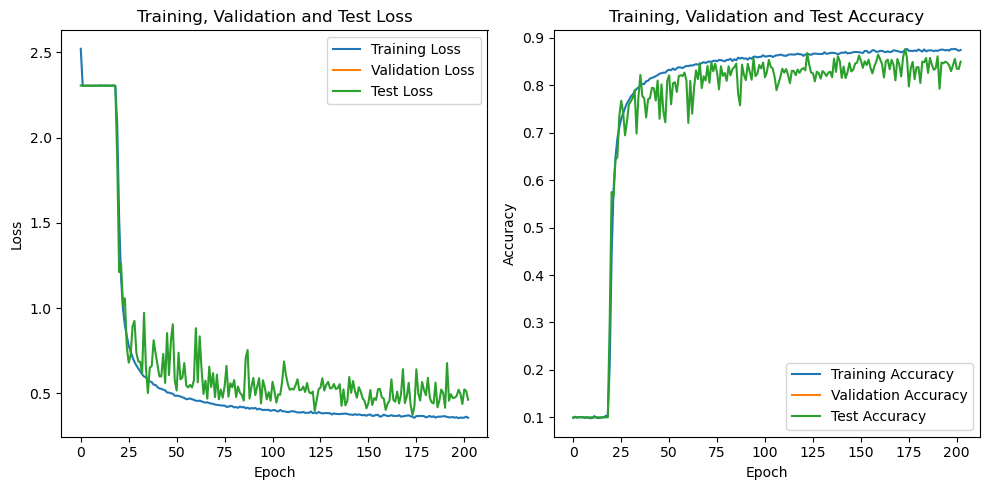

In [55]:
view = LogViewer(logs)
view.draw()

In [53]:
view.print_all()

1 epoch: train_loss=2.5204, train_acc=0.0988, test_loss=2.3053, test_acc=0.1000, lr=0.1000
2 epoch: train_loss=2.3043, train_acc=0.1012, test_loss=2.3045, test_acc=0.1000, lr=0.1000
3 epoch: train_loss=2.3044, train_acc=0.0990, test_loss=2.3032, test_acc=0.1000, lr=0.1000
4 epoch: train_loss=2.3040, train_acc=0.1008, test_loss=2.3043, test_acc=0.1000, lr=0.1000
5 epoch: train_loss=2.3043, train_acc=0.1001, test_loss=2.3042, test_acc=0.1000, lr=0.1000
6 epoch: train_loss=2.3042, train_acc=0.1004, test_loss=2.3032, test_acc=0.1000, lr=0.1000
7 epoch: train_loss=2.3043, train_acc=0.0986, test_loss=2.3030, test_acc=0.1000, lr=0.1000
8 epoch: train_loss=2.3041, train_acc=0.0999, test_loss=2.3047, test_acc=0.1000, lr=0.1000
9 epoch: train_loss=2.3044, train_acc=0.0989, test_loss=2.3044, test_acc=0.1000, lr=0.1000
10 epoch: train_loss=2.3045, train_acc=0.0981, test_loss=2.3036, test_acc=0.1000, lr=0.1000
11 epoch: train_loss=2.3043, train_acc=0.0987, test_loss=2.3059, test_acc=0.1000, lr=0.10

In [54]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))